# Capstone Project - The Battle of Neighborhoods
# Exploring the restaurants in NYC

### Introduction

New York City's demographics show that it is a large and ethnically diverse metropolis. It is the largest city in the United States with a long history of international immigration. New York City was home to nearly 8.5 million people in 2014, accounting for over 40% of the population of New York State and a slightly lower percentage of the New York metropolitan area, home to approximately 23.6 million. Over the last decade the city has been growing faster than the region. The New York region continues to be by far the leading metropolitan gateway for legal immigrants admitted into the United States.

Throughout its history, New York City has been a major point of entry for immigrants; the term "melting pot" was coined to describe densely populated immigrant neighborhoods on the Lower East Side. As many as 800 languages are spoken in New York, making it the most linguistically diverse city in the world. English remains the most widely spoken language, although there are areas in the outer boroughs in which up to 25% of people speak English as an alternate language, and/or have limited or no English language fluency. English is least spoken in neighborhoods such as Flushing, Sunset Park, and Corona.

With it's diverse culture , comes diverse food items. There are many resturants in New york City, each beloning to different categories like Italian, Chinese , Mexican , French etc.

.

### Table of Contents

For this project we need the following data :

1. New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude.
2. Data source : https://cocl.us/new_york_dataset/newyork_data.json : This data set contains the required information. And we will use this data set to explore variousneighborhoods of new york city.
3. Cluster in each neighborhood of new york city.
4. Data source : Fousquare API
5. Description : By using this api we will get all the venues in each neighborhood. 
6. We can filter these venues to get only Top resturants. 3. GeoSpace data
7. Data source : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
8. Description : By using this geo space data we will get the New york     
9. Borough boundaries that will help us visualize choropleth map.
10. Machine Learning Analysis to rank the top cuisines.

### Approach

1. Collect the new york city data from https://cocl.us/new_york_dataset
2. Using FourSquare API we will find all venues for each neighborhood.
3. Filter out all venues that are Indian Resturants.
4. Find rating , tips and like count for each Indian Resturants using FourSquare API.
5. Using rating for each resturant , we will sort that data.
6. Visualize the Ranking of neighborhoods using folium library(python)

## Questions that can be asked using the above mentioned datasets

1. Diversity of New york ?
2. Which areas consist of italian restaurants ?
3. Which areas have populous restaurant ?
4. Which cuisine do new yorkers prefer the most ?

### Methodology

We will import the required libraries for python.

1. pandas and numpy for handling data.
2. request module for using FourSquare API.
3. geopy to get co-ordinates of City of New York.
4. folium to visualize the results on a map

In [21]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from pprint import pprint # data pretty printer

import requests # library to handle requests
from bs4 import BeautifulSoup  # library to handle web scraping

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import folium # map rendering library

import matplotlib.cm as cm # Matplotlib and associated plotting modules
import matplotlib.colors as colors # Matplotlib and associated plotting modules

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from collections import Counter # count occurrences 

from sklearn.cluster import KMeans # import k-means from clustering stage

In [23]:
%pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9686 sha256=c41f5e078a0ccffd6c42cc3267bf67379654f50f38ce219c4e6b34d8801a5a8f
  Stored in directory: c:\users\amano\appdata\local\pip\cache\wheels\a1\b6\7c\0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
Note: you may need to restart the kernel to use updated packages.


In order to segment the neighborhoods of New York City, a dataset is required that contains the 5 boroughs and the neighborhoods, that exist in each borough, with respective latitude and longitude coordinates.

This dataset exists for free on the web. Here is the link

To the dataset: https://geo.nyu.edu/catalog/nyu_2451_34572, and
To its downloadable json format file: https://cocl.us/new_york_dataset/newyork_data.json

In [24]:
import wget
import os

if os.path.exists('newyork_data.json'):
    os.remove('newyork_data.json')

wget.download('https://cocl.us/new_york_dataset/newyork_data.json')

print('\nData downloaded!')

100% [........................................................] 115774 / 115774
Data downloaded!


In [25]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
type(newyork_data)

dict

In [26]:
print ("newyork_data key and value's length are: ") 
for key, value in newyork_data.items(): 
    print (key, len(str(value)))

newyork_data key and value's length are: 
type 17
totalFeatures 3
features 124743
crs 70
bbox 74



> All the relevant data is in the features key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.

In [27]:
neighborhoods_data = newyork_data['features']
pprint(neighborhoods_data[305])

{'geometry': {'coordinates': [-74.08173992211962, 40.61731079252983],
              'type': 'Point'},
 'geometry_name': 'geom',
 'id': 'nyu_2451_34572.306',
 'properties': {'annoangle': 0.0,
                'annoline1': 'Fox',
                'annoline2': 'Hills',
                'annoline3': None,
                'bbox': [-74.08173992211962,
                         40.61731079252983,
                         -74.08173992211962,
                         40.61731079252983],
                'borough': 'Staten Island',
                'name': 'Fox Hills',
                'stacked': 2},
 'type': 'Feature'}


> Transform to pandas

In [28]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


In [29]:
for data in neighborhoods_data:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [30]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [31]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


### Use geopy library to get long. and lat of the location

In [32]:
address = 'New York City, NY'
location = None

# define an instance of the geocoder -> ny_explorer
while location == None:
    try:
        geolocator = Nominatim(user_agent="ny_explorer")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
    except:
        pass
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


>Create a map

In [33]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

Folium is a great visualization library. Feel free to zoom into the above map, and click on each circle mark to reveal the name of the neighborhood and its respective borough

In [35]:
CLIENT_ID = 'JJH1FPTA14G1FL41OA1METPXFTTWJ1B2Y0FSPB4ELLZWZSBS' # your Foursquare ID
CLIENT_SECRET = 'JAO1AHJAM0XFHSJYCB1WOWZKF14EQ1TX4BT3X1IIVLPBVQO4' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JJH1FPTA14G1FL41OA1METPXFTTWJ1B2Y0FSPB4ELLZWZSBS
CLIENT_SECRET:JAO1AHJAM0XFHSJYCB1WOWZKF14EQ1TX4BT3X1IIVLPBVQO4


In [36]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)
category_results = requests.get(url).json()

In [37]:
for key, value in category_results['response']['categories'][0].items():
    print(key, len(str(value)))

id 24
name 20
pluralName 20
shortName 20
icon 98
categories 15910


In [38]:
category_list = category_results['response']['categories']

In [39]:
len(category_list)

10

In [40]:
for data in category_list:
    print(data['id'], data['name'])

4d4b7104d754a06370d81259 Arts & Entertainment
4d4b7105d754a06372d81259 College & University
4d4b7105d754a06373d81259 Event
4d4b7105d754a06374d81259 Food
4d4b7105d754a06376d81259 Nightlife Spot
4d4b7105d754a06377d81259 Outdoors & Recreation
4d4b7105d754a06375d81259 Professional & Other Places
4e67e38e036454776db1fb3a Residence
4d4b7105d754a06378d81259 Shop & Service
4d4b7105d754a06379d81259 Travel & Transport


> Food & It's Sub-Categories

Let's create a function to return a dictionary with Ids' & Names of Food & It's Sub-Categories.

In [41]:
# function to flatten a 'parent_id' category, returns all categories if checkParentID = False
def flatten_Hierarchy(category_list, checkParentID, category_dict, parent_id = ''):
    for data in category_list:
        
        if checkParentID == True and data['id'] == parent_id:
            category_dict[data['id']] = data['name']
            flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
        
        elif checkParentID == False:
            category_dict[data['id']] = data['name']
            if len(data['categories']) != 0:
                flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
    
    return category_dict

In [42]:
# this function takes the parent ID and returns 'name' and 'id' of all the sub-categories
category_dict = flatten_Hierarchy(category_list, checkParentID=True, category_dict = {}, parent_id = '4d4b7105d754a06374d81259')

Now, we have all the categories in Food with their id's.

In [43]:
neighborhoods.loc[0, 'Neighborhood']

'Wakefield'

In [44]:
neighborhood_latitude = neighborhoods.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhoods.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = neighborhoods.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Wakefield are 40.89470517661, -73.84720052054902.


In [45]:
LIMIT = 1 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
categoryId = '4d4b7105d754a06374d81259' # category ID for "Food"

# create URL

url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius,
    categoryId,
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/search?&client_id=JJH1FPTA14G1FL41OA1METPXFTTWJ1B2Y0FSPB4ELLZWZSBS&client_secret=JAO1AHJAM0XFHSJYCB1WOWZKF14EQ1TX4BT3X1IIVLPBVQO4&v=20180605&ll=40.89470517661,-73.84720052054902&radius=500&categoryId=4d4b7105d754a06374d81259&limit=1'

### Send the GET request and examine the resutls

In [46]:
results = requests.get(url).json()

In [47]:
results['response']['venues']

[{'id': '4c783cef3badb1f7e4244b54',
  'name': 'Carvel Ice Cream',
  'location': {'address': '1006 E 233rd St',
   'lat': 40.890486685759605,
   'lng': -73.84856772568665,
   'labeledLatLngs': [{'label': 'display',
     'lat': 40.890486685759605,
     'lng': -73.84856772568665},
    {'label': 'entrance', 'lat': 40.890438, 'lng': -73.848559}],
   'distance': 483,
   'postalCode': '10466',
   'cc': 'US',
   'city': 'Bronx',
   'state': 'NY',
   'country': 'United States',
   'formattedAddress': ['1006 E 233rd St',
    'Bronx, NY 10466',
    'United States']},
  'categories': [{'id': '4bf58dd8d48988d1c9941735',
    'name': 'Ice Cream Shop',
    'pluralName': 'Ice Cream Shops',
    'shortName': 'Ice Cream',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/icecream_',
     'suffix': '.png'},
    'primary': True}],
  'referralId': 'v-1593532503',
  'hasPerk': False}]

The category name of the venue 'Carvel Ice Cream' is 'Food'.

As, our aim is to segment the neighborhoods of NYC with respect to the Food in its vicinity. We need to proceed further to fetch this data from all the 306 neighborhoods' venues.

Let's create a function to repeat the following process to all the neighborhoods in NYC:
1. Loop through neighborhoods
2. Create the API request URL with radius=500, LIMIT=100
3. Make the GET request
4. For each neighborhood, return only relevant information for each nearby venue
5. Append all nearby venues to a list
6. Unfold the list & append it to dataframe being returned
7. The categoryId parameter in the API request URL can be a comma seperated string. So, lets create a comma seperated string from category_dict.

In [48]:
categoryId_list = []
for key, value in category_dict.items():
    categoryId_list.append(key)
categoryId = ','.join(categoryId_list)

In [49]:
def getNearbyFood(names, latitudes, longitudes, radius=1000, LIMIT=500):
    not_found = 0
    print('***Start ', end='')
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(' .', end='')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            "4d4b7105d754a06374d81259", # "Food" category id
            LIMIT)
            
        try:
            # make the GET request
            results = requests.get(url).json()['response']['venues']
            
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],  
                v['categories'][0]['name']) for v in results])
        except:
            not_found += 1


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print("\nDone*** with {} venues with incompelete information.".format(not_found))
    return(nearby_venues)

In [50]:
import pickle # to serialize and deserialize a Python object structure
try:
    with open('nyc_food_venues.pkl', 'rb') as f:
        nyc_venues = pickle.load(f)
    print("---Dataframe Existed and Deserialized---")
except:
    nyc_venues = getNearbyFood(names=neighborhoods['Neighborhood'],
                                        latitudes=neighborhoods['Latitude'],
                                        longitudes=neighborhoods['Longitude']
                                       )
    with open('nyc_food_venues.pkl', 'wb') as f:
        pickle.dump(nyc_venues, f)
    print("---Dataframe Created and Serialized---")

***Start  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Done*** with 1 venues with incompelete information.
---Dataframe Created and Serialized---


## We reach to analysis of our data
### we use k clustering

In [51]:
print(nyc_venues.shape)
nyc_venues.head()

(13670, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Central Deli,40.896728,-73.844387,Deli / Bodega
1,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
2,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop
3,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898083,-73.850259,Caribbean Restaurant
4,Wakefield,40.894705,-73.847201,Subway,40.897792,-73.855219,Sandwich Place


Let's find out how many unique categories can be curated from all the returned venues

In [52]:
print('There are {} uniques categories.'.format(len(nyc_venues['Venue Category'].unique())))
nyc_venues.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

There are 190 uniques categories.


Venue Category
Deli / Bodega                               1253
Pizza Place                                 1082
Coffee Shop                                  941
Chinese Restaurant                           678
Donut Shop                                   643
Fast Food Restaurant                         598
Bakery                                       589
Italian Restaurant                           446
Bagel Shop                                   404
Café                                         383
Mexican Restaurant                           373
Ice Cream Shop                               327
Sandwich Place                               325
Caribbean Restaurant                         318
Fried Chicken Joint                          311
American Restaurant                          303
Food                                         241
Diner                                        238
Restaurant                                   225
Food Truck                                   205
Burge

As we are interested in exploring the diversity of the neighborhood. Let's remove the generalized categories, like Coffee Shop, Cafe, etc.

In [53]:
# list all the categories
unique_categories = nyc_venues['Venue Category'].unique().tolist()
print(', '.join(str(x) for x in unique_categories))

Deli / Bodega, Ice Cream Shop, Donut Shop, Caribbean Restaurant, Sandwich Place, Food, Fast Food Restaurant, Fried Chicken Joint, Chinese Restaurant, Spanish Restaurant, Coffee Shop, Pizza Place, American Restaurant, Food Truck, Mexican Restaurant, Bagel Shop, Bakery, Seafood Restaurant, Dumpling Restaurant, BBQ Joint, African Restaurant, Restaurant, Diner, Grocery Store, Juice Bar, Wings Joint, Burger Joint, Asian Restaurant, Breakfast Spot, Café, Steakhouse, Sushi Restaurant, Tapas Restaurant, Empanada Restaurant, Latin American Restaurant, Bar, Japanese Restaurant, Italian Restaurant, Greek Restaurant, Frozen Yogurt Shop, Indian Restaurant, Thai Restaurant, Noodle House, Comfort Food Restaurant, Vegetarian / Vegan Restaurant, Korean Restaurant, Cuban Restaurant, Pub, Fish & Chips Shop, Falafel Restaurant, Cafeteria, Salvadoran Restaurant, Soup Place, Southern / Soul Food Restaurant, Other Nightlife, Arcade, New American Restaurant, Taco Place, Dessert Shop, Health Food Store, French

In [54]:
# manually create a list of generalized categories
general_categories = ['Dessert Shop','Food','Ice Cream Shop','Donut Shop','Bakery','Sandwich Place','Comfort Food Restaurant',
                    'Deli / Bodega','Food Truck','Bagel Shop','Burger Joint','Restaurant','Frozen Yogurt Shop','Coffee Shop',
                    'Diner','Wings Joint','Café','Juice Bar','Breakfast Spot','Grocery Store','Bar','Cupcake Shop',
                    'Pub','Fish & Chips Shop','Cafeteria','Other Nightlife','Arcade','Hot Dog Joint','Food Court',
                    'Health Food Store','Convenience Store','Food & Drink Shop','Cocktail Bar','Cheese Shop',
                    'Snack Place','Sports Bar','Lounge','Theme Restaurant','Buffet','Bubble Tea Shop','Building',
                    'Irish Pub','College Cafeteria','Tea Room','Supermarket','Hotpot Restaurant','Gastropub','Beer Garden',
                    'Fish Market','Beer Bar','Clothing Store','Music Venue','Bistro','Salad Place','Wine Bar','Gourmet Shop',
                    'Indie Movie Theater','Art Gallery','Gift Shop','Pie Shop','Fruit & Vegetable Store',
                    'Street Food Gathering','Dive Bar','Factory','Farmers Market','Mac & Cheese Joint','Creperie',
                    'Candy Store','Event Space','Skating Rink','Miscellaneous Shop','Gas Station','Organic Grocery',
                    'Pastry Shop','Club House','Flea Market','Hotel','Furniture / Home Store','Bookstore','Pet Café',
                    'Gym / Fitness Center','Flower Shop','Financial or Legal Service','Hotel Bar','Hookah Bar','Poke Place',
                    'Market','Gluten-free Restaurant','Smoothie Shop','Butcher','Food Stand','Beach Bar','Beach',
                    'Soup Place','Rock Club','Residential Building (Apartment / Condo)','Laundry Service',
                    'Government Building','Bowling Alley','Nightclub','Park','Moving Target']

In [55]:
# fetch all the required food categories
food_categories =  list(set(unique_categories) - set(general_categories))
print(', '.join(str(x) for x in food_categories))

Ukrainian Restaurant, Caribbean Restaurant, Pizza Place, Paella Restaurant, Indian Restaurant, Australian Restaurant, Eastern European Restaurant, Italian Restaurant, Polish Restaurant, German Restaurant, Taiwanese Restaurant, Shanghai Restaurant, Dosa Place, Burrito Place, North Indian Restaurant, Tex-Mex Restaurant, Persian Restaurant, Taco Place, Empanada Restaurant, Israeli Restaurant, Middle Eastern Restaurant, Vietnamese Restaurant, Egyptian Restaurant, Brazilian Restaurant, Moroccan Restaurant, Yemeni Restaurant, Chocolate Shop, Modern Greek Restaurant, Cajun / Creole Restaurant, Modern European Restaurant, Turkish Restaurant, Fast Food Restaurant, Szechuan Restaurant, BBQ Joint, Malay Restaurant, Record Shop, Russian Restaurant, Halal Restaurant, American Restaurant, Poutine Place, Sushi Restaurant, Ramen Restaurant, Indian Chinese Restaurant, Greek Restaurant, Bike Shop, French Restaurant, Asian Restaurant, Dumpling Restaurant, Dim Sum Restaurant, Falafel Restaurant, Beer Stor

In [56]:
nyc_venues = nyc_venues[nyc_venues['Venue Category'].isin(food_categories)].reset_index()
nyc_venues.head(5)

,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,3,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898083,-73.850259,Caribbean Restaurant
1,6,Wakefield,40.894705,-73.847201,Ali's Roti Shop,40.894036,-73.856935,Caribbean Restaurant
2,7,Wakefield,40.894705,-73.847201,Burger King,40.895540,-73.856460,Fast Food Restaurant
3,8,Wakefield,40.894705,-73.847201,Golden Krust Caribbean Restaurant,40.903773,-73.850051,Caribbean Restaurant
4,9,Wakefield,40.894705,-73.847201,Popeyes Louisiana Kitchen,40.889322,-73.843323,Fried Chicken Joint


In [57]:
print('There are {} unique FOOD categories.'.format(len(nyc_venues['Venue Category'].unique())))

There are 97 unique FOOD categories.


In [58]:
print('There are {} uniques venues.'.format(len(nyc_venues['Venue'].unique())))

There are 3160 uniques venues.


In [59]:
# one hot encoding
nyc_onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix="", prefix_sep="")
nyc_onehot.head()

,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Beer Store,Bike Shop,Brazilian Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Colombian Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dosa Place,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Service,French Restaurant,Fried Chicken Joint,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Hobby Shop,Indian Chinese Restaurant,Indian Restaurant,Indoor Play Area,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Record Shop,Russian Restaurant,Salvadoran Restaurant,Seafood Restaurant,Shanghai Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Turkish Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Yemeni Restaurant
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [60]:
# add neighborhood column back to dataframe
nyc_onehot['Neighborhood'] = nyc_venues['Neighborhood'] 
nyc_onehot.head()

,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Beer Store,Bike Shop,Brazilian Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Colombian Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dosa Place,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Service,French Restaurant,Fried Chicken Joint,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Hobby Shop,Indian Chinese Restaurant,Indian Restaurant,Indoor Play Area,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Record Shop,Russian Restaurant,Salvadoran Restaurant,Seafood Restaurant,Shanghai Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Turkish Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Yemeni Restaurant,Neighborhood
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield


In [61]:
# move neighborhood column to the first column
Neighborhood = nyc_onehot['Neighborhood']

nyc_onehot.drop(labels=['Neighborhood'], axis=1,inplace = True)
nyc_onehot.insert(0, 'Neighborhood', Neighborhood)

nyc_onehot.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Beer Store,Bike Shop,Brazilian Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Colombian Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dosa Place,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Service,French Restaurant,Fried Chicken Joint,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Hobby Shop,Indian Chinese Restaurant,Indian Restaurant,Indoor Play Area,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Record Shop,Russian Restaurant,Salvadoran Restaurant,Seafood Restaurant,Shanghai Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Turkish Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Yemeni Restaurant
0,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [62]:
nyc_onehot.shape

(6452, 98)

In [63]:
venue_counts = nyc_onehot.groupby('Neighborhood').sum()
venue_counts.head(5)

,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Beer Store,Bike Shop,Brazilian Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Colombian Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dosa Place,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Service,French Restaurant,Fried Chicken Joint,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Hobby Shop,Indian Chinese Restaurant,Indian Restaurant,Indoor Play Area,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Record Shop,Russian Restaurant,Salvadoran Restaurant,Seafood Restaurant,Shanghai Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Turkish Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Yemeni Restaurant
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Allerton,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,5,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Annadale,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0
Arden Heights,0,0,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0
Arlington,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Arrochar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


## Let's find out the top 10 food categories in NYC

In [64]:
venue_counts_described = venue_counts.describe().transpose()

In [65]:
venue_top10 = venue_counts_described.sort_values('max', ascending=False)[0:10]
venue_top10

,count,mean,std,min,25%,50%,75%,max
Korean Restaurant,301.0,0.239203,1.429193,0.0,0.0,0.0,0.0,22.0
Caribbean Restaurant,301.0,1.056478,2.374896,0.0,0.0,0.0,1.0,13.0
Chinese Restaurant,301.0,2.252492,1.883977,0.0,1.0,2.0,3.0,13.0
Fast Food Restaurant,301.0,1.986711,1.944177,0.0,0.0,2.0,3.0,11.0
Italian Restaurant,301.0,1.481728,1.767436,0.0,0.0,1.0,2.0,11.0
Indian Restaurant,301.0,0.308970,0.891190,0.0,0.0,0.0,0.0,10.0
Pizza Place,301.0,3.594684,1.998793,0.0,2.0,3.0,5.0,9.0
Seafood Restaurant,301.0,0.528239,0.892580,0.0,0.0,0.0,1.0,8.0
Fried Chicken Joint,301.0,1.033223,1.313605,0.0,0.0,1.0,2.0,7.0
Mexican Restaurant,301.0,1.239203,1.307386,0.0,0.0,1.0,2.0,6.0


In [66]:
venue_top10_list = venue_top10.index.values.tolist()

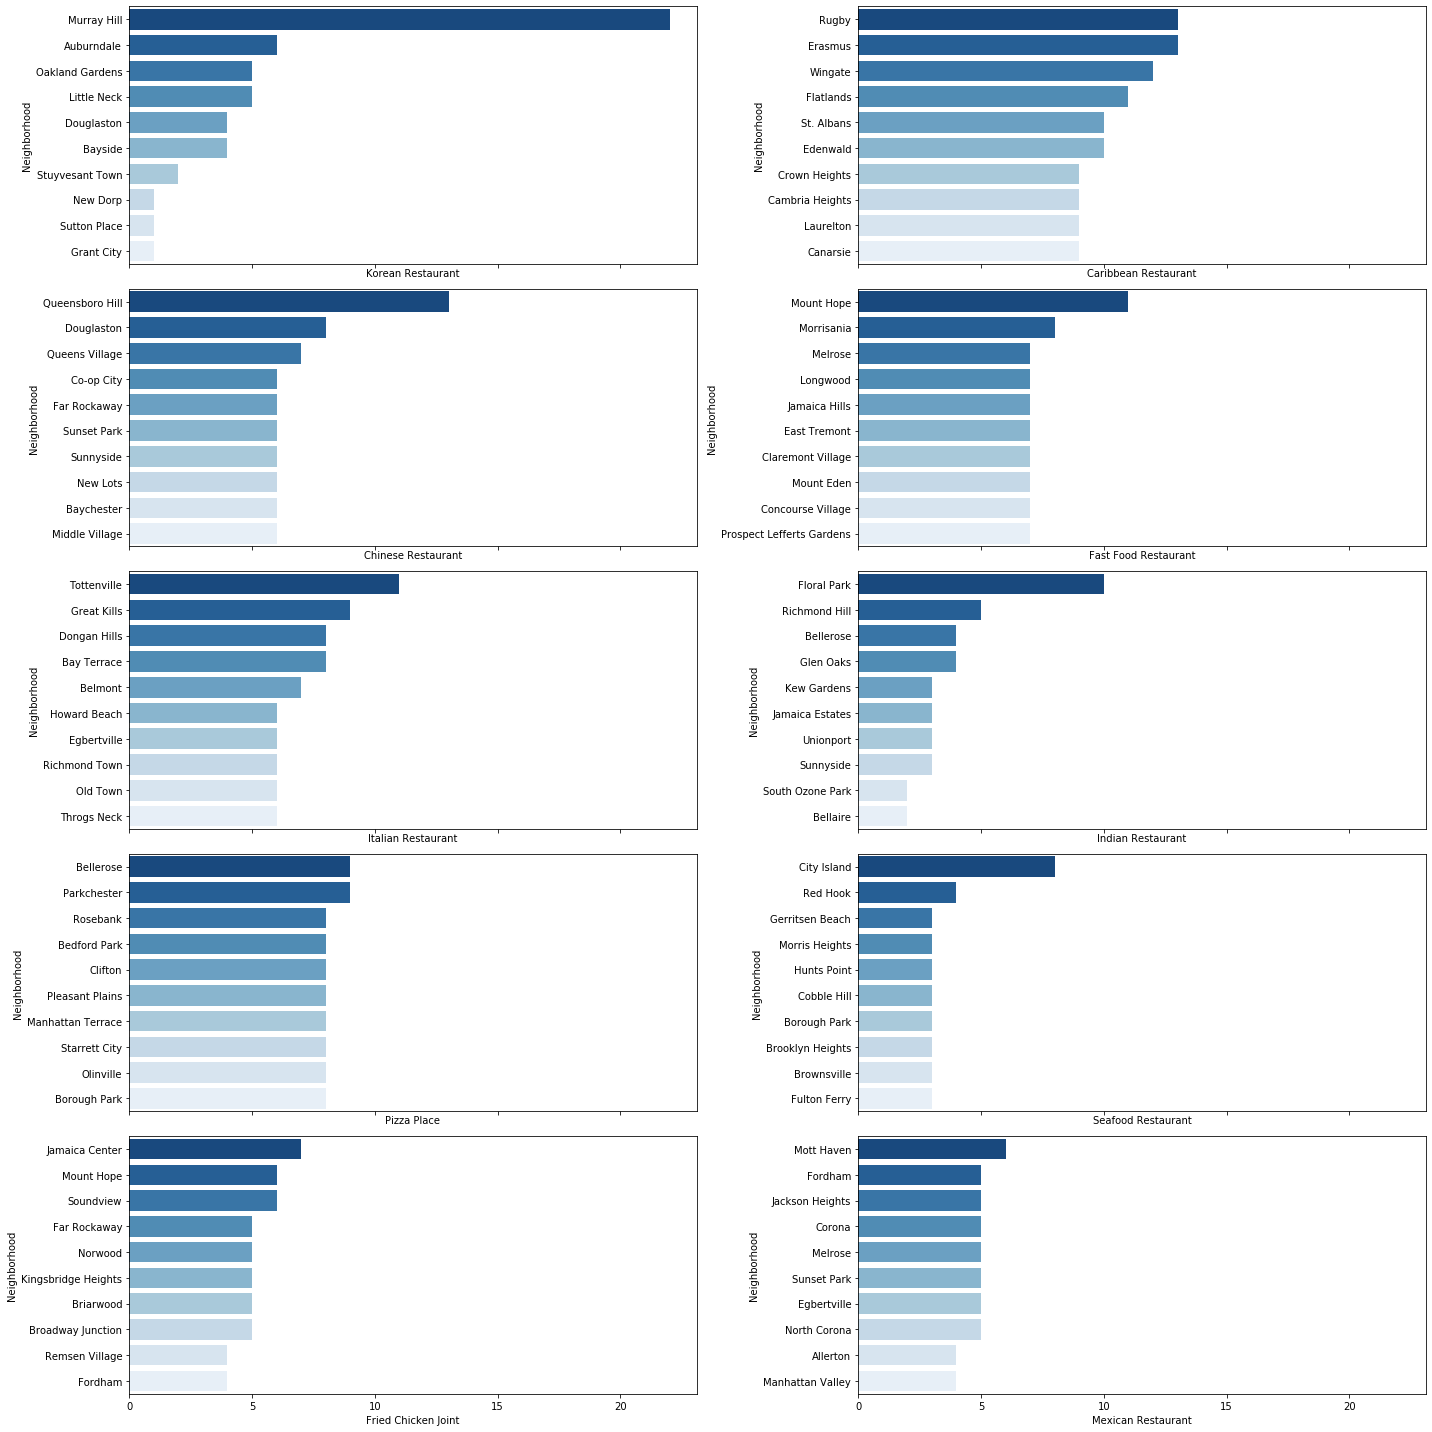

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes =plt.subplots(5, 2, figsize=(20,20), sharex=True)
axes = axes.flatten()

for ax, category in zip(axes, venue_top10_list):
    data = venue_counts[[category]].sort_values([category], ascending=False)[0:10]
    pal = sns.color_palette("Blues", len(data))
    sns.barplot(x=category, y=data.index, data=data, ax=ax, palette=np.array(pal[::-1]))

plt.tight_layout()
plt.show();

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [68]:
nyc_grouped = nyc_onehot.groupby('Neighborhood').mean().reset_index()
nyc_grouped.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Beer Store,Bike Shop,Brazilian Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Colombian Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dosa Place,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Service,French Restaurant,Fried Chicken Joint,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Hobby Shop,Indian Chinese Restaurant,Indian Restaurant,Indoor Play Area,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Record Shop,Russian Restaurant,Salvadoran Restaurant,Seafood Restaurant,Shanghai Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Turkish Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Yemeni Restaurant
0,Allerton,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.045455,0.0,0.227273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.136364,0.0,0.0,0.0,0.136364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.181818,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.227273,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045455,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Annadale,0.0,0.0,0.166667,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.055556,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.333333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.166667,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Arden Heights,0.0,0.0,0.157895,0.0,0.0,0.000000,0.0,0.0,0.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.105263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.157895,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.105263,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.315789,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.105263,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Arlington,0.0,0.0,0.111111,0.0,0.0,0.055556,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.055556,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.055556,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.055556,0.277778,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.111111,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Arrochar,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.076923,0.0,0.0

### Let's confirm the new size

In [69]:
nyc_grouped.shape

(301, 98)

### Let's write a function to sort the venues in descending order.¶


In [70]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [71]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))   

In [72]:
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = nyc_grouped['Neighborhood']

In [73]:
for ind in np.arange(nyc_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nyc_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Allerton,Pizza Place,Chinese Restaurant,Mexican Restaurant,Fried Chicken Joint,Fast Food Restaurant
1,Annadale,Pizza Place,Sushi Restaurant,American Restaurant,Italian Restaurant,Middle Eastern Restaurant
2,Arden Heights,Pizza Place,American Restaurant,Italian Restaurant,Sushi Restaurant,Mexican Restaurant
3,Arlington,Pizza Place,Spanish Restaurant,American Restaurant,Fast Food Restaurant,Polish Restaurant
4,Arrochar,Italian Restaurant,Pizza Place,Japanese Restaurant,Polish Restaurant,Latin American Restaurant


## Cluster Neighborhoods

In [74]:
nyc_grouped_clustering = nyc_grouped.drop('Neighborhood', 1)

The Elbow Method - calculate the sum of squared distances of samples to their closest cluster center for different values of k. The value of k after which there is no siginificant decrease in sum of squared distances is choosen.

In [75]:
sum_of_squared_distances = []
K = range(1,50)
for k in K:
    print(k, end=' ')
    kmeans = KMeans(n_clusters=k).fit(nyc_grouped_clustering)
    sum_of_squared_distances.append(kmeans.inertia_)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

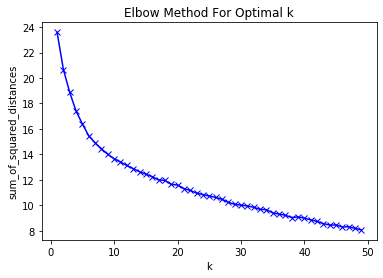

In [76]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k');

Elbow method does not seem to help us to determine the optimal number of clusters. Let's use another method.

The Silhouette Method - The silhouette value measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation). Source: Wikipedia

In [77]:
from sklearn.metrics import silhouette_score

sil = []
K_sil = range(2,50)
# minimum 2 clusters required, to define dissimilarity
for k in K_sil:
    print(k, end=' ')
    kmeans = KMeans(n_clusters = k).fit(nyc_grouped_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(nyc_grouped_clustering, labels, metric = 'euclidean'))

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

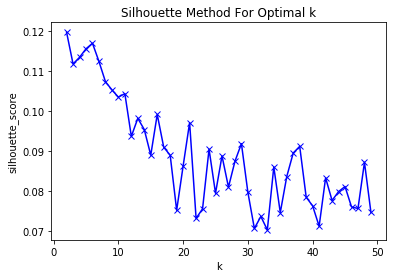

In [78]:
plt.plot(K_sil, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Silhouette Method For Optimal k')
plt.show()

There is a peak at k = 2, k = 4 and k = 8. Two and four clusters will give a very broad classification of the venues.

In [79]:
#Let's create a new dataframe that includes the cluster as well as the top 5 venues for each neighborhood.
# add clustering labels
try:
    neighborhoods_venues_sorted.drop('Cluster Labels', axis=1)
except:
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [80]:
neighborhoods_venues_sorted.head(5)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,15,Allerton,Pizza Place,Chinese Restaurant,Mexican Restaurant,Fried Chicken Joint,Fast Food Restaurant
1,35,Annadale,Pizza Place,Sushi Restaurant,American Restaurant,Italian Restaurant,Middle Eastern Restaurant
2,35,Arden Heights,Pizza Place,American Restaurant,Italian Restaurant,Sushi Restaurant,Mexican Restaurant
3,2,Arlington,Pizza Place,Spanish Restaurant,American Restaurant,Fast Food Restaurant,Polish Restaurant
4,34,Arrochar,Italian Restaurant,Pizza Place,Japanese Restaurant,Polish Restaurant,Latin American Restaurant


In [81]:
# merge neighborhoods_venues_sorted with nyc_data to add latitude/longitude for each neighborhood
nyc_merged = neighborhoods_venues_sorted.join(neighborhoods.set_index('Neighborhood'), on='Neighborhood')
nyc_merged.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
0,15,Allerton,Pizza Place,Chinese Restaurant,Mexican Restaurant,Fried Chicken Joint,Fast Food Restaurant,Bronx,40.865788,-73.859319
1,35,Annadale,Pizza Place,Sushi Restaurant,American Restaurant,Italian Restaurant,Middle Eastern Restaurant,Staten Island,40.538114,-74.178549
2,35,Arden Heights,Pizza Place,American Restaurant,Italian Restaurant,Sushi Restaurant,Mexican Restaurant,Staten Island,40.549286,-74.185887
3,2,Arlington,Pizza Place,Spanish Restaurant,American Restaurant,Fast Food Restaurant,Polish Restaurant,Staten Island,40.635325,-74.165104
4,34,Arrochar,Italian Restaurant,Pizza Place,Japanese Restaurant,Polish Restaurant,Latin American Restaurant,Staten Island,40.596313,-74.067124


Finally, let's visualize the resulting clusters

In [83]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_merged['Latitude'], nyc_merged['Longitude'], nyc_merged['Neighborhood'], nyc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [84]:
required_column_indices = [2,3,7]
required_column = [list(nyc_merged.columns.values)[i] for i in required_column_indices]
required_column_indices = [2,3,7]

In [85]:
cluster_0 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 0, nyc_merged.columns[1:12]]
cluster_0.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
7,Astoria Heights,Greek Restaurant,Pizza Place,Chinese Restaurant,Italian Restaurant,Indian Restaurant,Queens,40.770317,-73.894680
242,Sandy Ground,Pizza Place,Sushi Restaurant,Italian Restaurant,Chinese Restaurant,Mexican Restaurant,Staten Island,40.541140,-74.217766


In [86]:
for col in required_column:
    print(cluster_0[col].value_counts(ascending = False))
    print("---------------------------------------------")

Pizza Place         1
Greek Restaurant    1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Sushi Restaurant    1
Pizza Place         1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Staten Island    1
Queens           1
Name: Borough, dtype: int64
---------------------------------------------


### Cluster 1

In [87]:
cluster_1 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 1, nyc_merged.columns[1:12]]
cluster_1.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
17,Bedford Stuyvesant,Caribbean Restaurant,Fried Chicken Joint,Pizza Place,Southern / Soul Food Restaurant,French Restaurant,Brooklyn,40.687232,-73.941785
47,Central Harlem,Pizza Place,Fast Food Restaurant,Fried Chicken Joint,Southern / Soul Food Restaurant,American Restaurant,Manhattan,40.815976,-73.943211
141,Jamaica Center,Fried Chicken Joint,Fast Food Restaurant,Caribbean Restaurant,Pizza Place,Chinese Restaurant,Queens,40.704657,-73.796902
199,Ocean Hill,Fried Chicken Joint,Southern / Soul Food Restaurant,Pizza Place,Chinese Restaurant,Vegetarian / Vegan Restaurant,Brooklyn,40.678403,-73.913068
218,Prospect Lefferts Gardens,Fast Food Restaurant,Caribbean Restaurant,American Restaurant,Fried Chicken Joint,Empanada Restaurant,Brooklyn,40.658420,-73.954899


In [88]:
for col in required_column:
    print(cluster_1[col].value_counts(ascending = False))
    print("---------------------------------------------")

Fried Chicken Joint     2
Pizza Place             1
Caribbean Restaurant    1
Chinese Restaurant      1
Fast Food Restaurant    1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Fast Food Restaurant               2
Pizza Place                        1
Caribbean Restaurant               1
Fried Chicken Joint                1
Southern / Soul Food Restaurant    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Brooklyn     3
Queens       2
Manhattan    1
Name: Borough, dtype: int64
---------------------------------------------


### Cluster 2

In [89]:
cluster_2 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 2, nyc_merged.columns[1:12]]
cluster_2.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
3,Arlington,Pizza Place,Spanish Restaurant,American Restaurant,Fast Food Restaurant,Polish Restaurant,Staten Island,40.635325,-74.165104
39,Bushwick,Pizza Place,Asian Restaurant,Fast Food Restaurant,Thai Restaurant,Fried Chicken Joint,Brooklyn,40.698116,-73.925258
45,Castle Hill,Spanish Restaurant,American Restaurant,Pizza Place,Fried Chicken Joint,Latin American Restaurant,Bronx,40.819014,-73.848027
105,Fort Hamilton,Pizza Place,Fast Food Restaurant,Fried Chicken Joint,Italian Restaurant,Middle Eastern Restaurant,Brooklyn,40.614768,-74.031979
207,Parkchester,Pizza Place,Fast Food Restaurant,Latin American Restaurant,Spanish Restaurant,Mexican Restaurant,Bronx,40.837938,-73.856003


In [90]:
for col in required_column:
    print(cluster_2[col].value_counts(ascending = False))
    print("---------------------------------------------")

Pizza Place           8
Spanish Restaurant    1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Fast Food Restaurant    5
Spanish Restaurant      2
American Restaurant     1
Asian Restaurant        1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Bronx            4
Staten Island    2
Brooklyn         2
Queens           1
Name: Borough, dtype: int64
---------------------------------------------


### Cluster 3

In [91]:
cluster_3 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 3, nyc_merged.columns[1:12]]
cluster_3.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
10,Battery Park City,Fast Food Restaurant,Italian Restaurant,Mediterranean Restaurant,Pizza Place,American Restaurant,Manhattan,40.711932,-74.016869
43,Carnegie Hill,Mexican Restaurant,New American Restaurant,Italian Restaurant,American Restaurant,Pizza Place,Manhattan,40.782683,-73.953256
95,Financial District,Italian Restaurant,Fast Food Restaurant,Mexican Restaurant,American Restaurant,Pizza Place,Manhattan,40.707107,-74.010665
151,Lenox Hill,Mexican Restaurant,Taco Place,Falafel Restaurant,Thai Restaurant,French Restaurant,Manhattan,40.768113,-73.958860
153,Lincoln Square,Mexican Restaurant,Fast Food Restaurant,Pizza Place,American Restaurant,Taco Place,Manhattan,40.773529,-73.985338


In [92]:
for col in required_column:
    print(cluster_3[col].value_counts(ascending = False))
    print("---------------------------------------------")

Mexican Restaurant      5
American Restaurant     2
Italian Restaurant      1
Fast Food Restaurant    1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Fast Food Restaurant       2
Italian Restaurant         2
New American Restaurant    1
American Restaurant        1
Mexican Restaurant         1
Taco Place                 1
French Restaurant          1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Manhattan    9
Name: Borough, dtype: int64
---------------------------------------------


### Cluster 4

In [93]:
cluster_4 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 4, nyc_merged.columns[1:12]]
cluster_4.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
157,Long Island City,Italian Restaurant,American Restaurant,Pizza Place,Afghan Restaurant,BBQ Joint,Queens,40.750217,-73.939202
161,Malba,Italian Restaurant,Japanese Restaurant,Pizza Place,Taco Place,Sushi Restaurant,Queens,40.790602,-73.826678
222,Queensbridge,Italian Restaurant,Pizza Place,Japanese Restaurant,Afghan Restaurant,Steakhouse,Queens,40.756091,-73.945631
290,Whitestone,Pizza Place,Italian Restaurant,Japanese Restaurant,Greek Restaurant,Fast Food Restaurant,Queens,40.781291,-73.814202


In [94]:
for col in required_column:
    print(cluster_4[col].value_counts(ascending = False))
    print("---------------------------------------------")

Italian Restaurant    3
Pizza Place           1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Italian Restaurant     1
Pizza Place            1
Japanese Restaurant    1
American Restaurant    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Queens    4
Name: Borough, dtype: int64
---------------------------------------------


In [95]:
cluster_5 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 5, nyc_merged.columns[1:12]]
cluster_5.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
75,Dyker Heights,Pizza Place,Chinese Restaurant,Italian Restaurant,Fast Food Restaurant,Fried Chicken Joint,Brooklyn,40.619219,-74.019314
85,Edgemere,Pizza Place,Chinese Restaurant,Seafood Restaurant,Asian Restaurant,Caribbean Restaurant,Queens,40.595642,-73.776133
88,Elm Park,Pizza Place,Chinese Restaurant,Fast Food Restaurant,Sushi Restaurant,Italian Restaurant,Staten Island,40.630147,-74.141817
90,Eltingville,Pizza Place,Italian Restaurant,Fast Food Restaurant,Chinese Restaurant,Sushi Restaurant,Staten Island,40.542231,-74.164331
118,Gravesend,Pizza Place,Italian Restaurant,Fast Food Restaurant,Chinese Restaurant,Mexican Restaurant,Brooklyn,40.595260,-73.973471


In [96]:
for col in required_column:
    print(cluster_5[col].value_counts(ascending = False))
    print("---------------------------------------------")

Pizza Place    12
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Chinese Restaurant      7
Italian Restaurant      3
Indian Restaurant       1
Fast Food Restaurant    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Queens           3
Staten Island    3
Bronx            3
Brooklyn         3
Name: Borough, dtype: int64
---------------------------------------------


### Cluster 6

In [97]:
cluster_6 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 6, nyc_merged.columns[1:12]]
cluster_6.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
70,Ditmas Park,Pizza Place,Chinese Restaurant,Indian Restaurant,Middle Eastern Restaurant,Fast Food Restaurant,Brooklyn,40.643675,-73.961013
89,Elmhurst,Thai Restaurant,Fast Food Restaurant,Fried Chicken Joint,Chinese Restaurant,Mexican Restaurant,Queens,40.744049,-73.881656
96,Flatbush,Mexican Restaurant,Chinese Restaurant,Pizza Place,Indian Restaurant,Fast Food Restaurant,Brooklyn,40.636326,-73.958401
99,Floral Park,Indian Restaurant,Pizza Place,Fast Food Restaurant,Halal Restaurant,Fried Chicken Joint,Queens,40.741378,-73.708847
110,Gerritsen Beach,Pizza Place,Seafood Restaurant,Fried Chicken Joint,Thai Restaurant,Mexican Restaurant,Brooklyn,40.590848,-73.930102


In [98]:
for col in required_column:
    print(cluster_6[col].value_counts(ascending = False))
    print("---------------------------------------------")

Pizza Place             6
Fast Food Restaurant    3
Indian Restaurant       2
Mexican Restaurant      1
Thai Restaurant         1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Pizza Place                  3
Fast Food Restaurant         2
Chinese Restaurant           2
Middle Eastern Restaurant    1
Seafood Restaurant           1
Thai Restaurant              1
Spanish Restaurant           1
Italian Restaurant           1
Mexican Restaurant           1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Queens      6
Brooklyn    6
Bronx       1
Name: Borough, dtype: int64
---------------------------------------------


# Conclusion:
## The top restuarants are 


1. Deli / Bodega                               1253
2. Pizza Place                                 1082
3. Coffee Shop                                  941
4. Chinese Restaurant                           678
5. Donut Shop                                   643
6. Fast Food Restaurant                         598
7. Bakery                                       589
8. Italian Restaurant                           446
9. Bagel Shop                                   404
10. Café                                         383
11. Mexican Restaurant                           373

Note: This project didn't take 10 hours as was mentioned. it took 2 weeks.
    Thank you!
> **The scope** :  Clients interested in opening a new restaurant based on good locality and cuisine popularity